In [90]:
import requests
import os

import pandas as pd
import geopandas as gpd
from fiona.crs import from_epsg
import pyproj
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import unary_union

import matplotlib.pyplot as plt

import json
from pandas.io.json import json_normalize

from time import sleep, time
from IPython.core.display import clear_output

from itertools import product
from ast import literal_eval

%matplotlib inline

In [91]:
#Set the folder for APIKEY.py file
%cd "/home/jovyan/personal"

#Load API Keys
from APIKEY import GoogleKey_Cyrus

#Go back to previuos folder
%cd -

/home/jovyan/personal
/home/jovyan/nyu/Spring 2019/Urban Science Intensive I/Getting to Zero Capstone_/Data/Google Places


### Read place types

Get place types, and filter only the ones with assigned sop_variables. This list needs to be checked, I skipped place types where I'm not sure they will be useful.

In [92]:
place_types = pd.read_excel('place_types.xlsx')
place_types.head()

,type,sop_variable,skip
0,accounting,NaN,NaN
1,airport,NaN,NaN
2,amusement_park,recoher,NaN
3,aquarium,recoher,NaN
4,art_gallery,artgllry,NaN


In [93]:
place_types_fetch = place_types[~place_types.sop_variable.isnull() & place_types.skip.isnull()]
place_types_fetch.head()

,type,sop_variable,skip
2,amusement_park,recoher,NaN
3,aquarium,recoher,NaN
4,art_gallery,artgllry,NaN
7,bank,financl,NaN
8,bar,barsclub,NaN


In [94]:
len(place_types_fetch)

50

### Read NYC Neighborhoods

In [95]:
neighborhoods = gpd.read_file('Neighborhood Tabulation Areas.geojson')
neighborhoods.head()

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry
0,BK88,54005019.0709,047,Borough Park,39247.2280277,Brooklyn,3,(POLYGON ((-73.97604935657381 40.6312759056467...
1,QN51,52488276.867,081,Murray Hill,33266.9049948,Queens,4,(POLYGON ((-73.80379022888246 40.7756101117924...
2,QN27,19726845.4194,081,East Elmhurst,19816.7122926,Queens,4,(POLYGON ((-73.86109724401859 40.7636644770877...
3,QN07,22887772.8652,081,Hollis,20976.3355739,Queens,4,(POLYGON ((-73.75725671509139 40.7181386016625...
4,MN06,10647077.4989,061,Manhattanville,17040.6854134,Manhattan,1,(POLYGON ((-73.94607828674226 40.8212632160619...


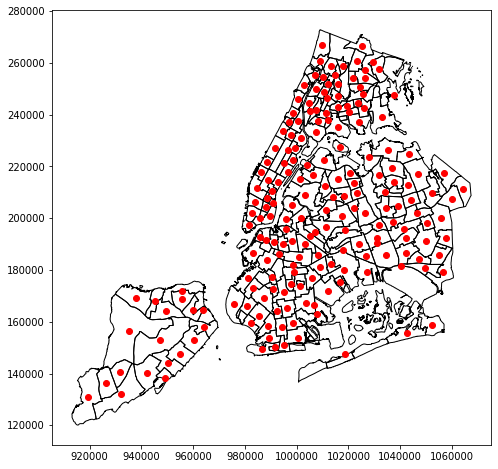

In [96]:
fig, ax = plt.subplots(figsize=(12,8))

neighborhoods.to_crs(epsg=2263).plot(ax=ax, facecolor='None', edgecolor='k')

neighborhoods.centroid.to_crs(epsg=2263).plot(ax=ax, color='red')

plt.show()

### Read already covered area per type

In [8]:
def get_place_type_coverage(place_type):
    proj = pyproj.Proj(init='epsg:2263', preserve_units=True)
    
    circles = []
    
    #Read all files fetched for place_type
    for f in os.listdir('raw'):
        if (place_type in f) and (f.endswith('csv')):
            df = pd.read_csv('raw/'+f)

            #Convert into GeoDataFrame
            df['geometry'] = df.apply(lambda x: Point(x['geometry.location.lng'], x['geometry.location.lat']), axis=1)
            places = gpd.GeoDataFrame(df)
            places.crs = from_epsg(4326)
            places = places.to_crs(epsg=2263)

            #Get center of fetched places
            center = Point(proj(float(f.split('_')[1]), float(f.split('_')[0])))

            #Get max distance
            distance = places.geometry.distance(center).max()

            #Create circle of max distance from center and append
            circles.append(center.buffer(distance))
    
    #Total coverage: unary union of circles
    final_coverage = unary_union(circles)
    
    return final_coverage

In [9]:
def get_all_coverages():
    place_type_coverage = []
    for p in place_types_fetch.type:
        place_type_coverage.append({
            'FeatureType': 'Polygon',
            'geometry': get_place_type_coverage(p),
            'properties': {
                'place_type': p
            }
        })

    place_type_coverage = gpd.GeoDataFrame().from_features(place_type_coverage)
    place_type_coverage.crs = from_epsg(2263)
    return place_type_coverage

In [ ]:
place_type_coverage = get_all_coverages()

Let's see if this worked

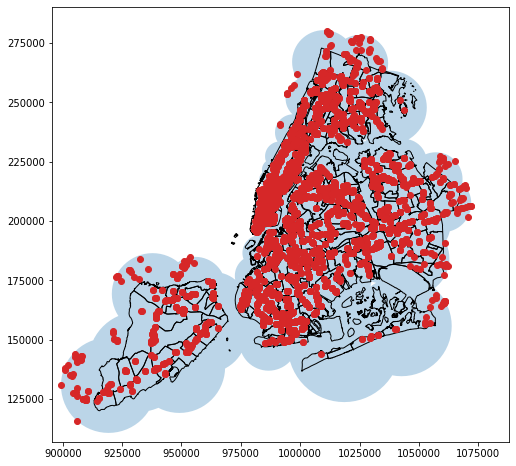

In [34]:
fig, ax = plt.subplots(figsize=(12,8))
place_type = 'bank'

df = pd.concat((pd.read_csv('raw/'+f) for f in os.listdir('raw') if (place_type in f)), ignore_index=True, sort=False)
df['geometry'] = df.apply(lambda x: Point(x['geometry.location.lng'], x['geometry.location.lat']), axis=1)
places = gpd.GeoDataFrame(df)
places.crs = from_epsg(4326)
places = places.to_crs(epsg=2263)

places.plot(ax=ax, color='tab:red', zorder=3)
place_type_coverage[place_type_coverage.place_type == place_type].plot(ax=ax, alpha=0.3, zorder=-1)
neighborhoods.to_crs(epsg=2263).plot(ax=ax, facecolor='None', edgecolor='k')

minx, miny, maxx, maxy = place_type_coverage.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.show()

**Note:** As we can see above we already covered entire neighborhoods with the place_type synagogue with only one API call. The idea is to recursively check this before calling the Google Places API to avoid API calls where we already have the data.

### Fetch data from Google Places API

Function to fetch places by type from Google Places API using nearby search from a specific lat/long. The API returns max 60 places for each search, and it paginates the response in pages of 20 results each (so there's a maximum of 3 pages per search). Additional pages are not counted as requests.

Each search costs \\$0.04 and there is a \\$200 monthly free tier (5000 of this kind of requests). Because we have 45 place types to fetch (or more, I'm only considering the ones I think are useful for the SOP variables), for a single lat/long we may need to do 45 requests. Not exaclty sure how many different lat longs we will need to check to cover all NYC.

In [97]:
def fetch_google_places(key, lat, long, place_type, next_page_token=None):

    if next_page_token is not None:
        url = 'https://maps.googleapis.com/maps/api/place/nearbysearch/json?location={},{}&pagetoken={}&rankby=distance&key={}'.format(
                lat, long, next_page_token, key)
    else:
        url = 'https://maps.googleapis.com/maps/api/place/nearbysearch/json?location={},{}&type={}&rankby=distance&key={}'.format(
                lat, long, place_type, key)
        
    resp = json.loads(requests.request('GET', url).content)

    status = resp['status']

    if (status == 'ZERO_RESULTS'):
        print(status)
        return pd.DataFrame(), None
        
    elif (status =='OK'):
        print(status)
        return json_normalize(resp['results']), resp.get('next_page_token', None)
    
    else:
        print(resp)
        raise Exception('Error in Google Places API request')

Fetch all place types from each Neighborhood centroid, only if its not already covered by prevous API calls. Also check if the file is already there to avoid duplicate requests.

I'll do it by boro to keep an eye on the request limit.

In [100]:
place_type

'amusement_park'

In [101]:
(place_type_coverage.place_type == place_type).sum()

1

In [102]:
place_type_coverage[place_type_coverage.place_type == place_type]

,geometry,place_type
0,None,amusement_park


In [98]:
total_requests = 1750
boro = 'Manhattan'
total_nbrhds = (neighborhoods.boro_name == boro).sum()
curr_nbrhds = 0
key = GoogleKey_Cyrus
refresh = True

for idx, nbrhd in neighborhoods[neighborhoods.boro_name == boro].iterrows():
    
    curr_nbrhds += 1
    
    print('{}, {}/{} in {}'.format(nbrhd.ntaname, curr_nbrhds, total_nbrhds, boro))
    
    #Stop way before limit just in case. I'm not sure I'm counting the requests correctly
    if total_requests > 3000:
        break
    
    #Redo this after each neighborhood fetch to include the latest places
    if refresh:
        place_type_coverage = []
        for p in place_types_fetch.type:
            place_type_coverage.append({
                'FeatureType': 'Polygon',
                'geometry': get_place_type_coverage(p),
                'properties': {
                    'place_type': p
                }
            })
        place_type_coverage = gpd.GeoDataFrame().from_features(place_type_coverage)
        place_type_coverage.crs = from_epsg(2263)
        
    refresh = False
    
    #Get centroid of neighborhood for the API call
    long = nbrhd.geometry.centroid.x
    lat = nbrhd.geometry.centroid.y
    
    #Convert to state plane to check intersection
    nbrhd_ft = gpd.GeoSeries(nbrhd.geometry)
    nbrhd_ft.crs = from_epsg(4326)
    #Only need the geometry
    nbrhd_ft = nbrhd_ft.to_crs(epsg=2263)[0]

    for place_type in place_types_fetch.type:

        i = 1

        fn = '{}_{}_{}.csv'.format(lat, long, place_type)

        #Check if we already downloaded this file
        if os.path.isfile('raw/{}'.format(fn)):
            print('{} already downloaded for {}'.format(place_type, nbrhd.ntaname))
            continue
        
        #Check if neighborhood is already covered for this place_type
        if nbrhd_ft.within(place_type_coverage[place_type_coverage.place_type == place_type].iloc[0,0]):
            print('{} already covered for {}'.format(place_type, nbrhd.ntaname))
            continue

        print('Fetching {} page {} for {}'.format(place_type, i, nbrhd.ntaname))

        df, next_page_token = fetch_google_places(key, lat, long, place_type)

        # Get additional pages in case there is any
        while (next_page_token is not None) & (i<3):

            i += 1

            print('Fetching {} page {} for {}'.format(place_type, i, nbrhd.ntaname))

            #Wait in between pages
            sleep(2)

            tmp_df, next_page_token = fetch_google_places(key, lat, long, place_type, next_page_token)

            df = df.append(tmp_df)
        
        if len(df) > 0: 
            df.to_csv('raw/{}'.format(fn), index=False)
        else:
            fn = '{}_{}_{}.empty'.format(lat, long, place_type)
            df.to_csv('raw/{}'.format(fn), index=False)
        
        total_requests += 1
        refresh = True

        clear_output(wait = True)

print('Done!')

Manhattanville, 1/29 in Manhattan


ValueError: Null geometry supports no operations

### Check areas not covered from Neighborhood centroids

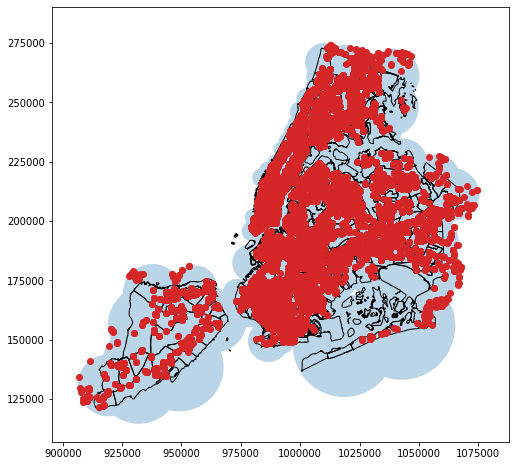

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
place_type = 'laundry'

df = pd.concat((pd.read_csv('raw/'+f) for f in os.listdir('raw') if (place_type in f)), ignore_index=True, sort=False)
df['geometry'] = df.apply(lambda x: Point(x['geometry.location.lng'], x['geometry.location.lat']), axis=1)
places = gpd.GeoDataFrame(df)
places.crs = from_epsg(4326)
places = places.to_crs(epsg=2263)

places.plot(ax=ax, color='tab:red', zorder=3)
place_type_coverage[place_type_coverage.place_type == place_type].plot(ax=ax, alpha=0.3, zorder=-1)
neighborhoods.to_crs(epsg=2263).plot(ax=ax, facecolor='None', edgecolor='k')

minx, miny, maxx, maxy = place_type_coverage.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.show()

In [11]:
#Useful function to tranform rows with MultiPolygons to multiple rows with Polygons
def explode(df):
    outdf = gpd.GeoDataFrame(columns=df.columns)
    for idx, row in df.iterrows():
        if type(row.geometry) == Polygon:
            outdf = outdf.append(row,ignore_index=True)
        if type(row.geometry) == MultiPolygon:
            multdf = gpd.GeoDataFrame(columns=df.columns)
            recs = len(row.geometry)
            multdf = multdf.append([row]*recs,ignore_index=True)
            for geom in range(recs):
                multdf.loc[geom,'geometry'] = row.geometry[geom]
            outdf = outdf.append(multdf,ignore_index=True)
    return outdf

In [14]:
place_type_coverage = get_all_coverages()

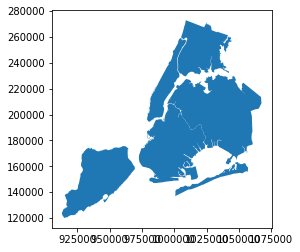

In [15]:
#Doing this to get rid of small islands
boros_exp = explode(neighborhoods.to_crs(epsg=2263).dissolve('boro_code'))
boros_exp['shape_area'] = boros_exp.geometry.area
boros_exp = boros_exp[boros_exp['shape_area'] > 50000000]
boros_exp.plot()

In [16]:
#Some neighborhoods are not covered because there where no results
no_results = {}
for idx, nbrhd in neighborhoods.iterrows():
    long = nbrhd.geometry.centroid.x
    lat = nbrhd.geometry.centroid.y
    
    #Convert to state plane to check intersection
    nbrhd_ft = gpd.GeoSeries(nbrhd.geometry)
    nbrhd_ft.crs = from_epsg(4326)
    #Only need the geometry
    nbrhd_ft = nbrhd_ft.to_crs(epsg=2263)[0]
    
    for place_type in place_types_fetch.type:
        fn = '{}_{}_{}.csv'.format(lat, long, place_type)
        
        if (not os.path.isfile('raw/{}'.format(fn))) and \
                (not nbrhd_ft.within(place_type_coverage[place_type_coverage.place_type == place_type].iloc[0,0])):
            
            if place_type in no_results:
                no_results[place_type] = unary_union([nbrhd_ft, no_results[place_type]])
            else:
                no_results[place_type] = nbrhd_ft

no_results_gdf = []
for k, v in no_results.items():
    no_results_gdf.append({
        'FeatureType': 'Polygon',
        'geometry': v,
        'properties': {
            'place_type': k
        }
    })
no_results_gdf = gpd.GeoDataFrame().from_features(no_results_gdf)
no_results_gdf.crs = from_epsg(2263)

In [17]:
no_results_gdf

,geometry,place_type
0,(POLYGON ((922555.4963989251 122443.1022338291...,hindu_temple
1,(POLYGON ((1021692.968627932 147138.6644286509...,city_hall
2,(POLYGON ((1016626.561584472 146409.8685912534...,courthouse
3,(POLYGON ((1048650.082397458 157173.0571898913...,bowling_alley
4,"POLYGON ((1049860.788635255 154842.3201903732,...",movie_theater


In [18]:
def check_empty_responses(place_type, geometry):
    proj = pyproj.Proj(init='epsg:2263', preserve_units=True)
    
    points = (Point(proj(float(f.split('_')[1]), float(f.split('_')[0])))
              for f in os.listdir('raw') if (f.endswith('empty') and (place_type in f)))
     
    return any(geometry.distance(p) < 1000 for p in points)

In [77]:
def get_uncovered_areas():
    not_covered = {}
    for place_type in place_types_fetch.type:
        #Get rid of places already covered
        diff = gpd.overlay(boros_exp, place_type_coverage[place_type_coverage.place_type == place_type], how='difference')

        #Don't consider places that had no results in previous run with Neighborhoods
        if place_type in no_results:
            diff = gpd.overlay(diff, no_results_gdf[no_results_gdf.place_type == place_type], how='difference')

        #Remove areas where response was empty
        diff = diff[~diff.geometry.apply(lambda x: check_empty_responses(place_type, x))]

        if len(diff):
            diff = explode(diff)
            diff['shape_area'] = diff.geometry.area
            diff.sort_values('shape_area', ascending=False, inplace=True)
            not_covered[place_type] = diff
    return not_covered

In [84]:
not_covered = get_uncovered_areas()

In [85]:
len(not_covered)

1

In [86]:
sum(len(v) for k, v in not_covered.items())

94

In [87]:
not_covered.keys()

dict_keys(['doctor'])

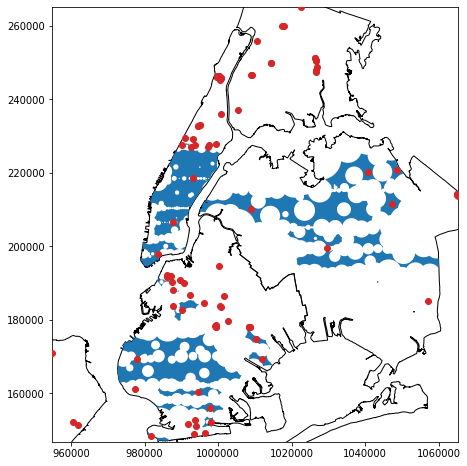

In [88]:
fig, ax = plt.subplots(figsize=(12,8))
place_type = 'doctor'

boros_exp.plot(ax=ax, facecolor='None', edgecolor='k')
not_covered[place_type].representative_point().plot(ax=ax, color='tab:red', zorder=3)
not_covered[place_type].plot(ax=ax)

minx, miny, maxx, maxy = not_covered[place_type].total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.show()

In [89]:
proj = pyproj.Proj(init='epsg:2263', preserve_units=True)
not_covered['doctor'].representative_point().apply(lambda x: proj(x.x,x.y, inverse=True))

49     (-74.02258000015512, 40.63161590210387)
90     (-73.91092890943793, 40.74341288855388)
5       (-73.967991953614, 40.766276075629584)
85     (-73.83651370619837, 40.71419190805528)
89     (-73.79643071649909, 40.77098928579343)
23    (-73.98748126037485, 40.733480197951664)
25     (-74.00202934753904, 40.70996003874678)
88      (-73.7723846605907, 40.74730812226478)
53      (-73.96256672504309, 40.6070381072141)
52     (-73.95112849776073, 40.59487751640679)
64     (-73.97835839964132, 40.66772804207193)
87     (-73.76772705839223, 40.77205927756153)
42     (-73.90001488155885, 40.63131397977832)
43      (-73.9063452171169, 40.64622021235865)
77    (-74.00886073288748, 40.573930082065594)
61     (-73.95051209264493, 40.58448055636954)
73    (-73.98873539407477, 40.688879729196955)
22      (-73.97824483206632, 40.7911762341151)
20    (-73.96810746900563, 40.795618266977705)
24     (-73.97546501477187, 40.79611974751695)
72     (-73.98763180326884, 40.68278456335875)
19       (-73

### Run again using representative points from areas not covered above

In [63]:
total_requests = 1956
key = GoogleKey_WeiYun
proj = pyproj.Proj(init='epsg:2263', preserve_units=True)

while (total_requests < 3000):

    print('Reloading data')
    
    place_type_coverage = get_all_coverages()
    not_covered = get_uncovered_areas()
    
    print('Remaining place_types:',list(not_covered.keys()))
    print('Total remaining areas:',sum(len(v) for k, v in not_covered.items()))
    
    sleep(2)

    for place_type, areas in not_covered.items():

        print('{}, {} areas not covered'.format(place_type, len(areas)))

        refresh = True

        #Stop way before limit just in case. I'm not sure I'm counting the requests correctly
        if total_requests > 3000:
            break

        for idx, area in enumerate(areas.geometry):

            #Get representative point of area for the API call (need to inverse project coords)
            long, lat = proj(area.representative_point().x, area.representative_point().y, inverse=True)

            i = 1

            fn = '{}_{}_{}.csv'.format(lat, long, place_type)

            #Redo this after each area fetch to include the latest places
            if refresh:
                ptype_coverage = get_place_type_coverage(place_type)
            refresh = False

            #Check if we already downloaded this file
            if os.path.isfile('raw/{}'.format(fn)):
                print('{} already downloaded for area {}/{}'.format(place_type, idx, len(areas)))
                continue

            #Check if area is already covered for this place_type
            if area.representative_point().within(ptype_coverage):
                print('{} already covered for area {}/{}'.format(place_type, idx, len(areas)))
                continue

            print('Fetching {} page {} for area {}/{}'.format(place_type, i, idx, len(areas)))

            df, next_page_token = fetch_google_places(key, lat, long, place_type)

            # Get additional pages in case there is any
            while (next_page_token is not None) & (i<3):

                i += 1

                print('Fetching {} page {} for area {}/{}'.format(place_type, i, idx,len(areas)))

                #Wait in between pages
                sleep(2)

                tmp_df, next_page_token = fetch_google_places(key, lat, long, place_type, next_page_token)

                df = df.append(tmp_df)

            if len(df) > 0: 
                df.to_csv('raw/{}'.format(fn), index=False)
            else:
                fn = '{}_{}_{}.empty'.format(lat, long, place_type)
                df.to_csv('raw/{}'.format(fn), index=False)

            total_requests += 1
            refresh = True

            clear_output(wait = True)

print('Done!')

jewelry_store, 5 areas not covered
jewelry_store already downloaded for area 0/5
jewelry_store already downloaded for area 1/5
jewelry_store already downloaded for area 2/5
jewelry_store already downloaded for area 3/5
jewelry_store already downloaded for area 4/5
Reloading data
Remaining place_types: ['clothing_store', 'doctor', 'jewelry_store']
Total remaining areas: 100
clothing_store, 1 areas not covered
clothing_store already downloaded for area 0/1
jewelry_store, 5 areas not covered
jewelry_store already downloaded for area 0/5
jewelry_store already downloaded for area 1/5
jewelry_store already downloaded for area 2/5
jewelry_store already downloaded for area 3/5
jewelry_store already downloaded for area 4/5
Reloading data
Remaining place_types: ['clothing_store', 'doctor', 'jewelry_store']
Total remaining areas: 100
clothing_store, 1 areas not covered
clothing_store already downloaded for area 0/1
jewelry_store, 5 areas not covered
jewelry_store already downloaded for area 0/5
j

KeyboardInterrupt: 

In [76]:
total_requests

1956

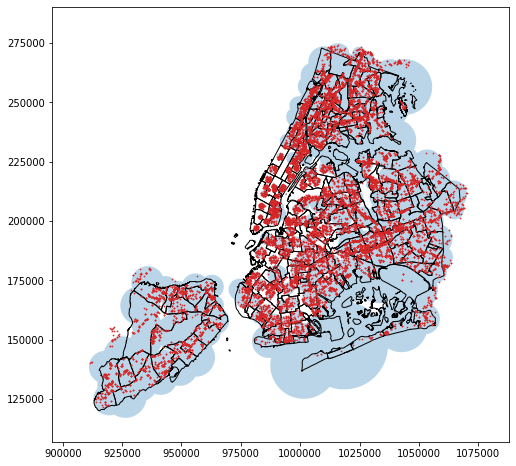

In [23]:
fig, ax = plt.subplots(figsize=(12,8))
place_type = 'home_goods_store'

df = pd.concat((pd.read_csv('raw/'+f) for f in os.listdir('raw') if (place_type in f)), ignore_index=True, sort=False)
df['geometry'] = df.apply(lambda x: Point(x['geometry.location.lng'], x['geometry.location.lat']), axis=1)
places = gpd.GeoDataFrame(df)
places.crs = from_epsg(4326)
places = places.to_crs(epsg=2263)

places.plot(ax=ax, color='tab:red', zorder=3, markersize=0.5)
place_type_coverage[place_type_coverage.place_type == place_type].plot(ax=ax, alpha=0.3, zorder=-1)
neighborhoods.to_crs(epsg=2263).plot(ax=ax, facecolor='None', edgecolor='k')

minx, miny, maxx, maxy = place_type_coverage.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.show()

In [24]:
place_type_coverage2 = []
for p in place_types_fetch.type:
    place_type_coverage2.append({
        'FeatureType': 'Polygon',
        'geometry': get_place_type_coverage(p),
        'properties': {
            'place_type': p
        }
    })
    
place_type_coverage2 = gpd.GeoDataFrame().from_features(place_type_coverage2)
place_type_coverage2.crs = from_epsg(2263)

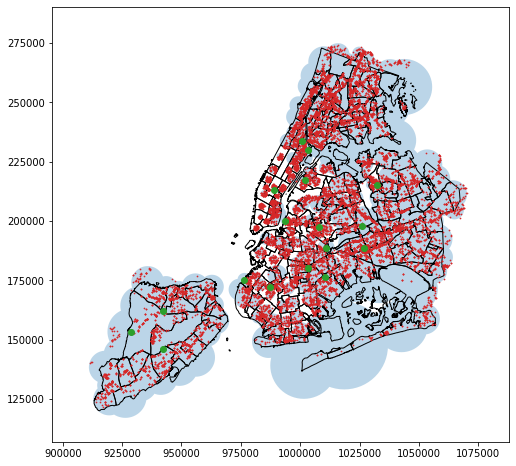

In [27]:
fig, ax = plt.subplots(figsize=(12,8))
place_type = 'home_goods_store'

df = pd.concat((pd.read_csv('raw/'+f) for f in os.listdir('raw') if (place_type in f)), ignore_index=True, sort=False)
df['geometry'] = df.apply(lambda x: Point(x['geometry.location.lng'], x['geometry.location.lat']), axis=1)
places = gpd.GeoDataFrame(df)
places.crs = from_epsg(4326)
places = places.to_crs(epsg=2263)

places.plot(ax=ax, color='tab:red', zorder=3, markersize=0.5)
place_type_coverage2[place_type_coverage2.place_type == place_type].plot(ax=ax, alpha=0.3, zorder=-1)
neighborhoods.to_crs(epsg=2263).plot(ax=ax, facecolor='None', edgecolor='k')
not_covered[place_type].representative_point().plot(ax=ax, color='tab:green', zorder=3)

minx, miny, maxx, maxy = place_type_coverage2.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.show()

### Check data

Read CSVs into one dataframe

In [443]:
place_type = 'doctor'

df = pd.concat((pd.read_csv('raw/'+f) for f in os.listdir('raw') if (place_type in f) & f.endswith('csv')), ignore_index=True, sort=False)
df.head()

,geometry.location.lat,geometry.location.lng,geometry.viewport.northeast.lat,geometry.viewport.northeast.lng,geometry.viewport.southwest.lat,geometry.viewport.southwest.lng,icon,id,name,opening_hours.open_now,photos,place_id,plus_code.compound_code,plus_code.global_code,rating,reference,scope,types,user_ratings_total,vicinity
0,40.505427,-74.240378,40.506753,-74.239147,40.504055,-74.241845,https://maps.gstatic.com/mapfiles/place_api/ic...,f57746ace38a4add81162338017c07cce098fca1,"Dr. Joel Brock, MD",NaN,NaN,ChIJ2TdilqLKw4kR_a83snaHyRk,"GQ45+5R New York, United States",87G7GQ45+5R,NaN,ChIJ2TdilqLKw4kR_a83snaHyRk,GOOGLE,"['doctor', 'health', 'point_of_interest', 'est...",NaN,"479 Sleight Avenue, Staten Island"
1,40.502593,-74.245925,40.503969,-74.244436,40.501271,-74.247134,https://maps.gstatic.com/mapfiles/place_api/ic...,022eb561e1b0c121f071003bb028b6740e0dc5c6,"Michael Peccerillo, RD",NaN,NaN,ChIJUx-SIZfKw4kR7coQf1BVstA,"GQ33+2J New York, United States",87G7GQ33+2J,NaN,ChIJUx-SIZfKw4kR7coQf1BVstA,GOOGLE,"['doctor', 'health', 'point_of_interest', 'est...",NaN,"242 Swinnerton Street, Staten Island"
2,40.502059,-74.241350,40.503379,-74.240144,40.500681,-74.242842,https://maps.gstatic.com/mapfiles/place_api/ic...,f2727a0d9179cb46e80b94af7dcc099c874e4b41,Berger Diane,NaN,NaN,ChIJbQ_vfb3Kw4kRFtUUF6Bfh4E,"GQ25+RF New York, United States",87G7GQ25+RF,NaN,ChIJbQ_vfb3Kw4kRFtUUF6Bfh4E,GOOGLE,"['doctor', 'health', 'point_of_interest', 'est...",NaN,"331 Manhattan Street, Staten Island"
3,40.501578,-74.246586,40.502956,-74.245089,40.500258,-74.247787,https://maps.gstatic.com/mapfiles/place_api/ic...,133cc99e71c0b7630d4f8072f934a5b7f70e5fc2,R Cipriano Inc,NaN,NaN,ChIJtV5dz5bKw4kR1JBqJT-iUuk,"GQ23+J9 New York, United States",87G7GQ23+J9,NaN,ChIJtV5dz5bKw4kR1JBqJT-iUuk,GOOGLE,"['doctor', 'health', 'point_of_interest', 'est...",NaN,"272 Carteret Street, Staten Island"
4,40.508778,-74.242473,40.509989,-74.241166,40.507291,-74.243864,https://maps.gstatic.com/mapfiles/place_api/ic...,0a026b86a713315fabbdbfebed5aaeb9c5248a05,Bottiglieri Thomas S DO,NaN,NaN,ChIJU-bIsJjKw4kRMHiPCeLhtak,"GQ55+G2 New York, United States",87G7GQ55+G2,NaN,ChIJU-bIsJjKw4kRMHiPCeLhtak,NaN,"['doctor', 'health', 'point_of_interest', 'est...",NaN,"505 Academy Avenue, Staten Island"


In [444]:
len(df)

25260

Check duplicates

In [445]:
df.place_id.duplicated().sum()

6768

In [448]:
df[~df.place_id.duplicated()].sort_values('place_id').tail()

,geometry.location.lat,geometry.location.lng,geometry.viewport.northeast.lat,geometry.viewport.northeast.lng,geometry.viewport.southwest.lat,geometry.viewport.southwest.lng,icon,id,name,opening_hours.open_now,photos,place_id,plus_code.compound_code,plus_code.global_code,rating,reference,scope,types,user_ratings_total,vicinity
13937,40.721827,-73.848795,40.723096,-73.847497,40.720398,-73.850195,https://maps.gstatic.com/mapfiles/place_api/ic...,9a538cc76c3b9dd7d475885e5dabafcab95e8165,"Dr. Danny S. Sperling, MD",NaN,NaN,ChIJzzYJDiRewokRnjuYosbYv_Q,"P5C2+PF New York, United States",87G8P5C2+PF,NaN,ChIJzzYJDiRewokRnjuYosbYv_Q,GOOGLE,"['doctor', 'health', 'point_of_interest', 'est...",NaN,"69-15 Austin Street, Forest Hills"
13938,40.721822,-73.848804,40.723094,-73.847504,40.720396,-73.850202,https://maps.gstatic.com/mapfiles/place_api/ic...,b38d8e49744624c373f84ed9a413f9ad1d36469e,Complete Care,NaN,NaN,ChIJzzYJDiRewokRvw_gUE1C9YE,"P5C2+PF New York, United States",87G8P5C2+PF,5.0,ChIJzzYJDiRewokRvw_gUE1C9YE,NaN,"['doctor', 'health', 'point_of_interest', 'est...",1.0,"6915 Austin Street # 1, Forest Hills"
13977,40.721561,-73.849261,40.722962,-73.848031,40.720264,-73.850729,https://maps.gstatic.com/mapfiles/place_api/ic...,NaN,Dr. Sherman Chan,NaN,NaN,ChIJzzYJDiRewokRy3YGdzYpUOM,"P5C2+J7 New York, United States",87G8P5C2+J7,1.0,ChIJzzYJDiRewokRy3YGdzYpUOM,GOOGLE,"['doctor', 'health', 'point_of_interest', 'est...",1.0,"69-02 Austin Street, Forest Hills"
9715,40.663893,-73.994894,40.665178,-73.993438,40.662480,-73.996136,https://maps.gstatic.com/mapfiles/place_api/ic...,NaN,"Jaime D. Misle, PA",NaN,NaN,ChIJzzeWWO9awokRvTa4uMSeHSk,"M274+H2 New York, United States",87G8M274+H2,NaN,ChIJzzeWWO9awokRvTa4uMSeHSk,GOOGLE,"['doctor', 'health', 'point_of_interest', 'est...",NaN,"660 4th Avenue, Brooklyn"
2162,40.576522,-73.989350,40.577887,-73.987873,40.575189,-73.990571,https://maps.gstatic.com/mapfiles/place_api/ic...,NaN,"Raquel A. Payne, MS",NaN,NaN,ChIJzzf2jMlFwokRoLi5SgyTNQo,"H2G6+J7 New York, United States",87G8H2G6+J7,NaN,ChIJzzf2jMlFwokRoLi5SgyTNQo,GOOGLE,"['doctor', 'health', 'point_of_interest', 'est...",NaN,"2872 West 22nd Street, Brooklyn"


**Note:** Each place can have more than one type, that's why there are some duplicates. I had a major issue in my code where most places where duplicated, now it's fixed.

In [312]:
df = df[~df.place_id.duplicated()]

In [313]:
#Combine lat long into a tuple column
df['lonlat'] = list(zip(df['geometry.location.lng'], df['geometry.location.lat']))
#Create Point feature in geometry column
df['geometry'] = df.lonlat.apply(lambda x: Point(x))
df.drop('lonlat', axis=1, inplace=True)

gdf = gpd.GeoDataFrame(df)
#Set CRS
gdf.crs = from_epsg(4326)

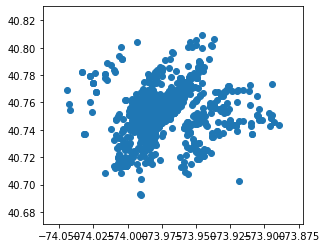

In [314]:
gdf.plot()

In [315]:
gdf.to_file('out/Places_{}_{}.geojson'.format(lat, long), driver='GeoJSON')

### Check overlapping place types

In [320]:
ptypes = df.types.apply(lambda x: literal_eval(x))
all_types = list({item for sublist in ptypes for item in sublist}) + ['total'] #add total at the end
matrix = pd.DataFrame(index=all_types, columns=all_types).fillna(0)

In [321]:
skip = ['establishment', 'point_of_interest', 'food', 'store']

for sublist in ptypes:
    for i,j in product(sublist, repeat=2):
        if  (i not in skip) and (j not in skip):
            if (i != j):
                matrix.loc[i,j] = matrix.loc[i,j] + 1
                #matrix.loc[j,i] = matrix.loc[j,i] + 1
            else:
                matrix.loc[i,'total'] = matrix.loc[i,'total'] + 1

In [322]:
len([l for l in [item for sublist in ptypes for item in sublist] if l == 'book_store'])

61

In [323]:
max_not_self = pd.DataFrame(matrix.idxmax(axis=1).pipe(lambda x: x[x!='total']), columns=['max_other'])
max_not_self['n'] = [matrix.loc[idx, row['max_other']] for idx, row in max_not_self.iterrows()]
max_not_self

,max_other,n
physiotherapist,health,6
plumber,home_goods_store,5
movie_rental,book_store,1
university,book_store,1
pharmacy,health,62
hindu_temple,place_of_worship,14
post_office,finance,60
supermarket,grocery_or_supermarket,60
city_hall,local_government_office,16
synagogue,place_of_worship,60


In [292]:
pd.read_csv('raw/40.75356553157895_-73.97056993684211_bicycle_store.csv')

,geometry.location.lat,geometry.location.lng,geometry.viewport.northeast.lat,geometry.viewport.northeast.lng,geometry.viewport.southwest.lat,geometry.viewport.southwest.lng,icon,id,name,opening_hours.open_now,photos,place_id,plus_code.compound_code,plus_code.global_code,rating,reference,scope,types,user_ratings_total,vicinity
0,40.753810,-73.968149,40.755195,-73.966774,40.752497,-73.969472,https://maps.gstatic.com/mapfiles/place_api/ic...,3bfdba48e97b337592c341b41c03221ff87606df,Kickstand Bicycles,False,"[{'height': 648, 'html_attributions': ['<a hre...",ChIJyzjEYuJYwokR5rorW1qho8s,"Q23J+GP New York, United States",87G8Q23J+GP,4.6,ChIJyzjEYuJYwokR5rorW1qho8s,NaN,"['bicycle_store', 'store', 'point_of_interest'...",106.0,"316 East 49th Street, New York"
1,40.748477,-73.970752,40.749849,-73.969456,40.747151,-73.972154,https://maps.gstatic.com/mapfiles/place_api/ic...,fc20e5df32410c75ab1f59b338770f418b05b844,Conrad's Bike Shop,False,"[{'height': 648, 'html_attributions': ['<a hre...",ChIJN4VFrxxZwokRLCQGEkMZmoA,"P2XH+9M New York, United States",87G8P2XH+9M,4.6,ChIJN4VFrxxZwokRLCQGEkMZmoA,GOOGLE,"['bicycle_store', 'store', 'point_of_interest'...",47.0,"25 Tudor City Place, New York"
2,40.761063,-73.962994,40.762342,-73.961696,40.759644,-73.964394,https://maps.gstatic.com/mapfiles/place_api/ic...,ff4fd66d55813c7b49364c913b6a592b1d187f09,Spokesman Cycles,False,"[{'height': 480, 'html_attributions': ['<a hre...",ChIJuSXyNuZYwokR3wLLbKKm7GM,"Q26P+CR New York, United States",87G8Q26P+CR,3.5,ChIJuSXyNuZYwokR3wLLbKKm7GM,GOOGLE,"['bicycle_store', 'car_repair', 'store', 'poin...",53.0,"313 East 60th Street, New York"
3,40.762203,-73.976745,40.763643,-73.975329,40.760946,-73.978027,https://maps.gstatic.com/mapfiles/place_api/ic...,NaN,Rent Bike Nyc,False,NaN,ChIJDVxSL_pYwokRqiRl8LCOwk4,"Q26F+V8 New York, United States",87G8Q26F+V8,5.0,ChIJDVxSL_pYwokRqiRl8LCOwk4,GOOGLE,"['bicycle_store', 'store', 'point_of_interest'...",1.0,"40 West 55th Street, New York"
4,40.750576,-73.984347,40.752034,-73.982920,40.749336,-73.985618,https://maps.gstatic.com/mapfiles/place_api/ic...,efa5562885b22d32c3ab6920bfc4714aac56e79e,Rollgood Electric Bicycle & Scooter Store,False,"[{'height': 3036, 'html_attributions': ['<a hr...",ChIJnTYWH6pZwokRy2A-oO5qZac,"Q228+67 New York, United States",87G8Q228+67,4.7,ChIJnTYWH6pZwokRy2A-oO5qZac,GOOGLE,"['bicycle_store', 'store', 'point_of_interest'...",129.0,"16 West 37th Street, New York"
5,40.750600,-73.984357,40.752051,-73.982936,40.749353,-73.985634,https://maps.gstatic.com/mapfiles/place_api/ic...,170fdfb9c77a73e841ef5d1dfee23665d00d4c92,Couture Inc.,False,"[{'height': 1536, 'html_attributions': ['<a hr...",ChIJxV4pI6pZwokR4H9VGeclwcE,"Q228+67 New York, United States",87G8Q228+67,5.0,ChIJxV4pI6pZwokR4H9VGeclwcE,GOOGLE,"['bicycle_store', 'store', 'point_of_interest'...",2.0,"16 West 37th Street, New York"
6,40.763345,-73.977008,40.764682,-73.975668,40.761984,-73.978365,https://maps.gstatic.com/mapfiles/place_api/ic...,50e4e00630b6e19d7a14393f10ee8e79c0dbad8d,Cycle Central Park,False,"[{'height': 500, 'html_attributions': ['<a hre...",ChIJHVXDKvhYwokRVdiOdJ0SIRc,"Q27F+85 New York, United States",87G8Q27F+85,3.8,ChIJHVXDKvhYwokRVdiOdJ0SIRc,GOOGLE,"['bicycle_store', 'store', 'point_of_interest'...",47.0,"54 West 56th Street, New York"
7,40.762242,-73.983126,40.763656,-73.981954,40.760958,-73.984652,https://maps.gstatic.com/mapfiles/place_api/ic...,58b07cf7b23f084409f326a60fc4846978f6e4f1,BikeNYoga,False,"[{'height': 1536, 'html_attributions': ['<a hr...",ChIJYci4K1ZYwokRL-vWFpIeCQA,"Q268+VP New York, United States",87G8Q268+VP,5.0,ChIJYci4K1ZYwokRL-vWFpIeCQA,GOOGLE,"['gym', 'bicycle_store', 'health', 'store', 'p...",3.0,"1666 Broadway, New York"
8,40.765461,-73.977266,40.766725,-73.975979,40.764027,-73.978677,https://maps.gstatic.com/mapfiles/place_api/ic...,541ca7b3a86cbc8e9caa20f366f6c49ad53c9d2c,Central Park Bike Rentals,False,"[{'height': 1067, 'html_attributions': ['<a hr...",ChIJ13xrNfdYwokRtZbKLr1Vmd0,"Q28F+53 New Yor